<center><font size=6> Bank Churn Prediction </font></center>

## Problem Statement

### Context

Businesses like banks which provide service have to worry about problem of 'Customer Churn' i.e. customers leaving and joining another service provider. It is important to understand which aspects of the service influence a customer's decision in this regard. Management can concentrate efforts on improvement of service, keeping in mind these priorities.

### Objective

You as a Data scientist with the  bank need to  build a neural network based classifier that can determine whether a customer will leave the bank  or not in the next 6 months.

### Data Dictionary

* CustomerId: Unique ID which is assigned to each customer

* Surname: Last name of the customer

* CreditScore: It defines the credit history of the customer.
  
* Geography: A customer’s location
   
* Gender: It defines the Gender of the customer
   
* Age: Age of the customer
    
* Tenure: Number of years for which the customer has been with the bank

* NumOfProducts: refers to the number of products that a customer has purchased through the bank.

* Balance: Account balance

* HasCrCard: It is a categorical variable which decides whether the customer has credit card or not.

* EstimatedSalary: Estimated salary

* isActiveMember: Is is a categorical variable which decides whether the customer is active member of the bank or not ( Active member in the sense, using bank products regularly, making transactions etc )

* Exited : whether or not the customer left the bank within six month. It can take two values
** 0=No ( Customer did not leave the bank )
** 1=Yes ( Customer left the bank )

In [ ]:
# !pip install tensorflow==2.15.0 scikit-learn==1.2.2 seaborn==0.13.1 matplotlib==3.7.1 numpy==1.26.4 pandas==2.2.1 imbalanced-learn==0.10.1 -q --user

## Importing necessary libraries

In [ ]:
# Libraries to help with reading and manipulating data
import pandas as pd
import numpy as np

# libaries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Library to split data
from sklearn.model_selection import train_test_split

from sklearn.exceptions import DataConversionWarning
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    ConfusionMatrixDisplay,
    classification_report
)
# library to import to standardize the data
from sklearn.preprocessing import StandardScaler, LabelEncoder


# importing different functions to build models
import tensorflow as tf
from tensorflow import keras
from keras import backend
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.metrics import Recall

# importing SMOTE
from imblearn.over_sampling import SMOTE


import random

# Library to avoid the warnings
import warnings

warnings.filterwarnings("ignore")

from typing import Tuple, List
from IPython.display import display

pd.options.display.float_format = "{:.2f}".format
pd.options.display.max_columns = None
pd.options.display.max_rows = 200
pd.options.display.max_colwidth = 400
pd.set_option("display.float_format", lambda x: "%.2f" % x)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 200)

## Loading the dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

data = pd.read_csv('/content/drive/MyDrive/Projects/Nueral_Network/data.csv')
df = data.copy()


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


####**Define Data Utility Class**

In [ ]:
class DataUtility:
    def __init__(self, df):
        self.df = df

    def drop_column(self, col):
        self.df.drop(col, axis=1, inplace=True, errors='ignore')

    def clean_column_names(self):
        self.df.columns = self.df.columns.str.lower().str.replace(' ', '_').str.strip()

    def find_unique_id_cols(self):
        unique_id_columns = self.df.columns[(self.df.nunique() == len(self.df)) & (~self.df.isnull().any())]
        return list(unique_id_columns)

    def convert_to_categorical(self, categorical_cols):
      for col in categorical_cols:
          if col in self.df.columns:
              self.df[col] = self.df[col].astype('category')
          else:
              print(f"Column '{col}' not found in DataFrame.")

    def analyze_categorical_cols(self, categorical_cols):
        category_analysis = {}
        for col in categorical_cols:
            if col in self.df.columns:
                count = self.df[col].value_counts()
                percentage = self.df[col].value_counts(normalize=True) * 100
                category_analysis[col] = pd.DataFrame({'Count': count, 'Percentage': percentage})

        insights = {}
        for col, analysis in category_analysis.items():
            insights[col] = analysis.apply(lambda x: f"{x.name}: {x['Count']} ({x['Percentage']:.2f}%)", axis=1).values

        for col, col_insights in insights.items():
            print(f"{col}:\n" + "\n".join(col_insights) + "\n")

    def analyze_numeric_cols(self, numeric_cols):
        for col in numeric_cols:
            if col in self.df.columns:
                mean_value = self.df[col].mean()
                median_value = self.df[col].median()
                min_value = self.df[col].min()
                max_value = self.df[col].max()
                std_dev = self.df[col].std()
                quartiles = self.df[col].quantile([0.25, 0.75])

                print(f"{col}")
                print(f"Mean: {mean_value:.2f}")
                print(f"Median: {median_value:.2f}")
                print(f"Range: {min_value} - {max_value}")
                print(f"Standard Deviation: {std_dev:.2f}")
                print(f"25th Percentile: {quartiles[0.25]}")
                print(f"75th Percentile: {quartiles[0.75]}\n")

    def analyze_discrete_columns(self, uniqueness_threshold=10):
        discrete_columns = []
        for column in self.df.columns:
            if pd.api.types.is_numeric_dtype(self.df[column]):
                if self.df[column].nunique() <= uniqueness_threshold:
                    discrete_columns.append(column)
        return discrete_columns

    def analyze_missing_data(self):
        # percentage of null values
        null_summary = self.dataframe.isnull().sum()
        null_percentage = (self.dataframe.isnull().mean()) * 100

        # hold the summary
        summary_df = pd.DataFrame(
            {"Null Count": null_summary, "Null Percentage": null_percentage}
        )

        # missing values and sort by percentage
        summary_df = summary_df[summary_df["Null Count"] > 0].sort_values(
            by="Null Percentage", ascending=False
        )

        print(summary_df)

In [ ]:
#instatiate the helper
datautil = DataUtility(df)

## Data Overview


- Observations
- Sanity checks


In [ ]:
# display first and last few rows of data
pd.concat([df.head(10), df.tail(10)])

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2,134603.88,1,1,1,71725.73,0


In [ ]:
df.shape

(10000, 14)

**Observations:**

- The dataset contains 10000 rows, 14 data points

In [ ]:
df.dtypes

RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

**Observations**

- The dataset contains 10 int, 5 float, 6 categorical

In [ ]:
def analyze_missing_data(df):
        # percentage of null values
        null_summary = df.isnull().sum()
        null_percentage = (df.isnull().mean()) * 100

        # hold the summary
        summary_df = pd.DataFrame(
            {"Null Count": null_summary, "Null Percentage": null_percentage}
        )

        # missing values and sort by percentage
        summary_df = summary_df[summary_df["Null Count"] > 0].sort_values(
            by="Null Percentage", ascending=False
        )

        print(summary_df)

In [ ]:
analyze_missing_data(df)

Empty DataFrame
Columns: [Null Count, Null Percentage]
Index: []


**Observations:**

- No nulls

In [ ]:
df.duplicated().sum()

0

**Observations:**

- No Duplicates

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
RowNumber,10000.00,5000.50,2886.90,1.00,2500.75,5000.50,7500.25,10000.00
CustomerId,10000.00,15690940.57,71936.19,15565701.00,15628528.25,15690738.00,15753233.75,15815690.00
CreditScore,10000.00,650.53,96.65,350.00,584.00,652.00,718.00,850.00
Age,10000.00,38.92,10.49,18.00,32.00,37.00,44.00,92.00
Tenure,10000.00,5.01,2.89,0.00,3.00,5.00,7.00,10.00
Balance,10000.00,76485.89,62397.41,0.00,0.00,97198.54,127644.24,250898.09
NumOfProducts,10000.00,1.53,0.58,1.00,1.00,1.00,2.00,4.00
HasCrCard,10000.00,0.71,0.46,0.00,0.00,1.00,1.00,1.00
IsActiveMember,10000.00,0.52,0.50,0.00,0.00,1.00,1.00,1.00
EstimatedSalary,10000.00,100090.24,57510.49,11.58,51002.11,100193.91,149388.25,199992.48


In [ ]:
df.select_dtypes(include=['object']).describe()

,Surname,Geography,Gender
count,10000,10000,10000
unique,2932,3,2
top,Smith,France,Male
freq,32,5014,5457


In [ ]:
df.nunique()

RowNumber          10000
CustomerId         10000
Surname             2932
CreditScore          460
Geography              3
Gender                 2
Age                   70
Tenure                11
Balance             6382
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary     9999
Exited                 2
dtype: int64

**Observations**
- RowNumber: This appears to be an identifier similar to an index, which we can  drop.

- CustomerId and Surname: Should not be included in the feature set for model training due to their non-predictive nature.

- CreditScore, Age, Tenure, Balance, NumOfProducts, EstimatedSalary: These are numerical features that might require scaling.

- Geography, Gender, HasCrCard, IsActiveMember: Categorical features that will need to be encoded.


####**Drop Columns**

In [ ]:
df = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)



####**Type Conversion**

In [ ]:
df['Geography'] = df['Geography'].astype('category')
df['Gender'] = df['Gender'].astype('category')



In [ ]:
# check for conversion
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   CreditScore      10000 non-null  int64   
 1   Geography        10000 non-null  category
 2   Gender           10000 non-null  category
 3   Age              10000 non-null  int64   
 4   Tenure           10000 non-null  int64   
 5   Balance          10000 non-null  float64 
 6   NumOfProducts    10000 non-null  int64   
 7   HasCrCard        10000 non-null  int64   
 8   IsActiveMember   10000 non-null  int64   
 9   EstimatedSalary  10000 non-null  float64 
 10  Exited           10000 non-null  int64   
dtypes: category(2), float64(2), int64(7)
memory usage: 723.0 KB


Observation

* category(2), float64(2), int64(7)

## Exploratory Data Analysis

In [ ]:
#### The below functions need to be defined to carry out the Exploratory Data Analysis.

def create_plots(data, col):
  min_val = data[col].min()
  max_val = data[col].max()
  q1 = data[col].quantile(0.25)
  q2 = data[col].quantile(0.50)
  q3 = data[col].quantile(0.75)
  iqr = q3 - q1
  mode_val = data[col].mode()[0]
  skewness = data[col].skew()
  data_range = max_val - min_val
  unique_count = data[col].nunique()
  non_missing_count = data[col].count()
  zeroes_count = (data[col] == 0).sum()

  stats_dict = {
      'Min': min_val, 'Max': max_val, 'Q1': q1, 'Q2': q2, 'Q3': q3,
      'IQR': iqr, 'Mode': mode_val, 'Skewness': skewness, 'Range': data_range,
      'Unique': unique_count, 'Non-Missing': non_missing_count,
      'Zeroes Count': zeroes_count
  }

  stats_df = pd.DataFrame(data=stats_dict, index=['Value'])
  display(stats_df)

  sns.set(style='whitegrid', palette='tab20')

  fig, axes = plt.subplots(2, 2, figsize=(16, 8), dpi=75)
  fig.subplots_adjust(hspace=0.6, wspace=0.4)

  # histplot
  sns.histplot(data[col], kde=True, color='purple', ax=axes[0, 0])
  axes[0, 0].axvline(data[col].mean(), color='purple', linestyle="--")
  axes[0, 0].axvline(data[col].median(), color='black', linestyle="-")
  axes[0, 0].set_title(f'{col.capitalize()} Frequency Distribution')

  # boxplot
  sns.boxplot(x=data[col], palette='Set2', width=0.7, linewidth=0.6, showmeans=True, ax=axes[1, 0])
  axes[1, 0].set_title(f'{col.capitalize()} Boxplot')

  # violinplot
  sns.violinplot(x=data[col], palette='tab20', split=False, ax=axes[0, 1])
  axes[0, 1].set_title(f'{col.capitalize()} Violinplot')

  # cumulative distribution
  sns.kdeplot(data[col], cumulative=True, palette='Pastel1', ax=axes[1, 1])
  axes[1, 1].set_title(f'{col.capitalize()} Cumulative Distribution')

  plt.show()


### Univariate Analysis

####**Numerical Univariate Plots**

 Creditscore 


,Min,Max,Q1,Q2,Q3,IQR,Mode,Skewness,Range,Unique,Non-Missing,Zeroes Count
Value,350,850,584.00,652.00,718.00,134.00,850,-0.07,500,460,10000,0


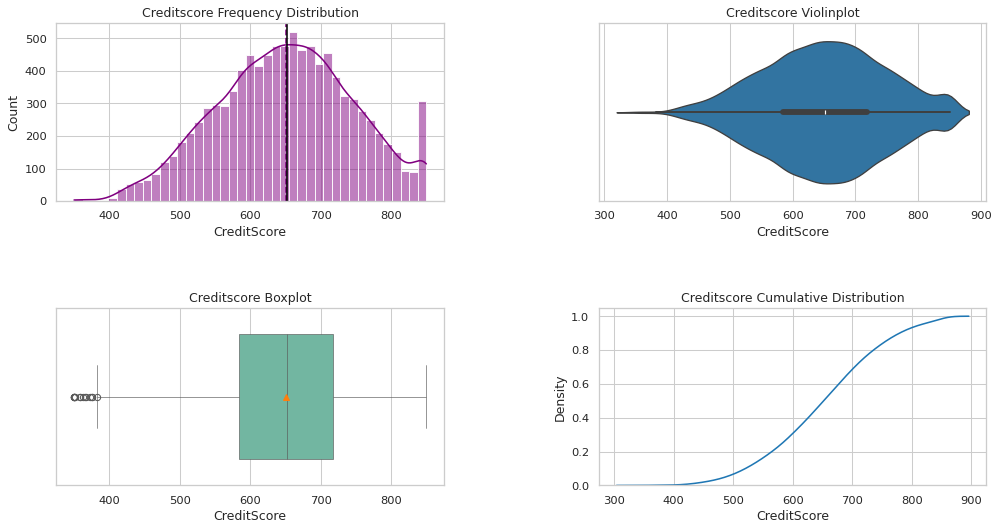




 Age 


,Min,Max,Q1,Q2,Q3,IQR,Mode,Skewness,Range,Unique,Non-Missing,Zeroes Count
Value,18,92,32.00,37.00,44.00,12.00,37,1.01,74,70,10000,0


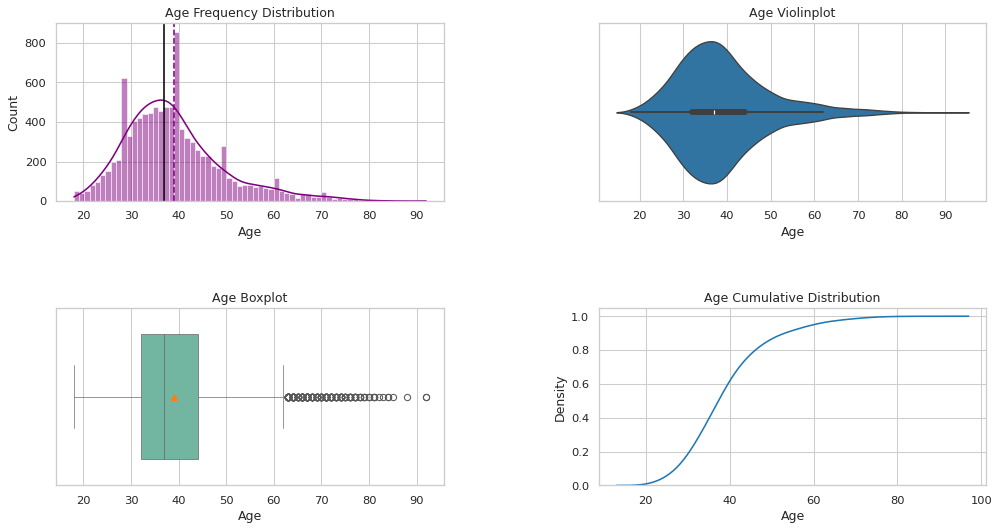




 Tenure 


,Min,Max,Q1,Q2,Q3,IQR,Mode,Skewness,Range,Unique,Non-Missing,Zeroes Count
Value,0,10,3.00,5.00,7.00,4.00,2,0.01,10,11,10000,413


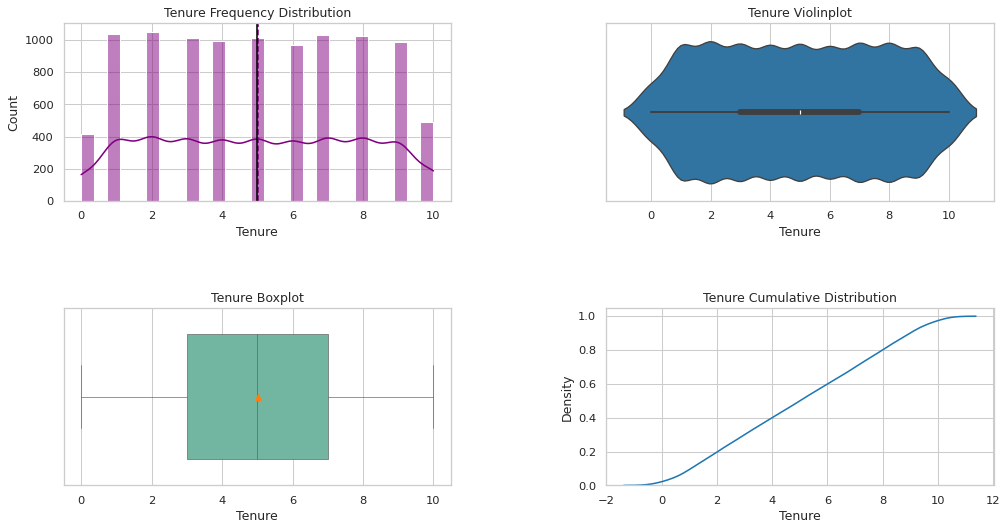




 Balance 


,Min,Max,Q1,Q2,Q3,IQR,Mode,Skewness,Range,Unique,Non-Missing,Zeroes Count
Value,0.00,250898.09,0.00,97198.54,127644.24,127644.24,0.00,-0.14,250898.09,6382,10000,3617


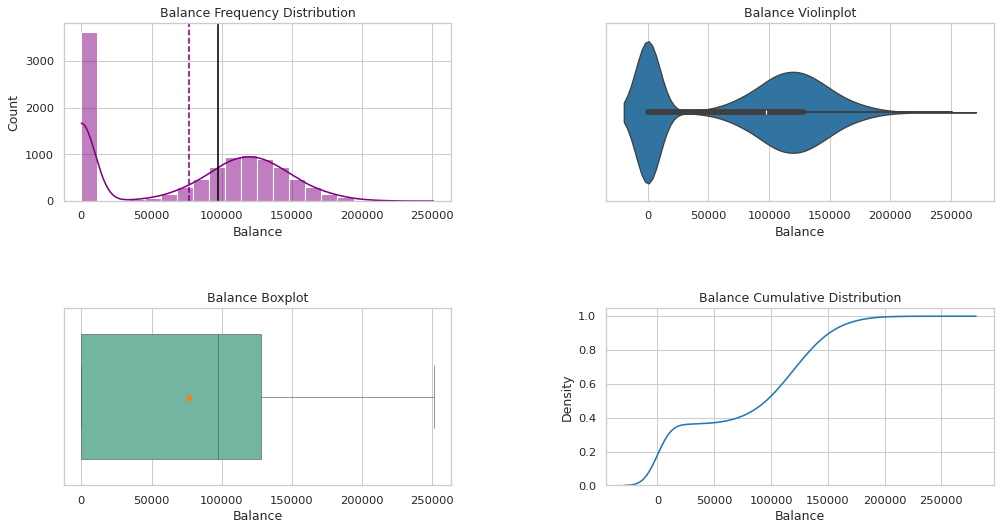




 Numofproducts 


,Min,Max,Q1,Q2,Q3,IQR,Mode,Skewness,Range,Unique,Non-Missing,Zeroes Count
Value,1,4,1.00,1.00,2.00,1.00,1,0.75,3,4,10000,0


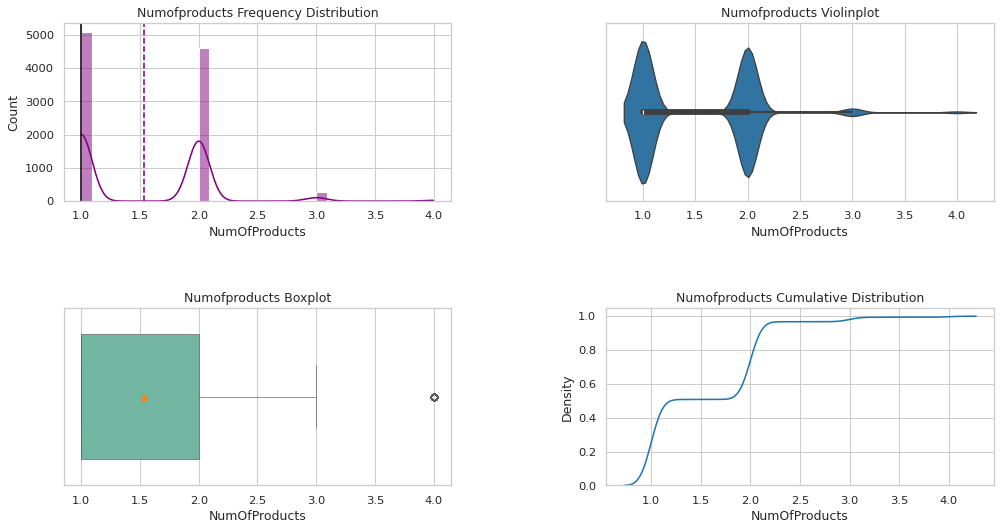




 Hascrcard 


,Min,Max,Q1,Q2,Q3,IQR,Mode,Skewness,Range,Unique,Non-Missing,Zeroes Count
Value,0,1,0.00,1.00,1.00,1.00,1,-0.90,1,2,10000,2945


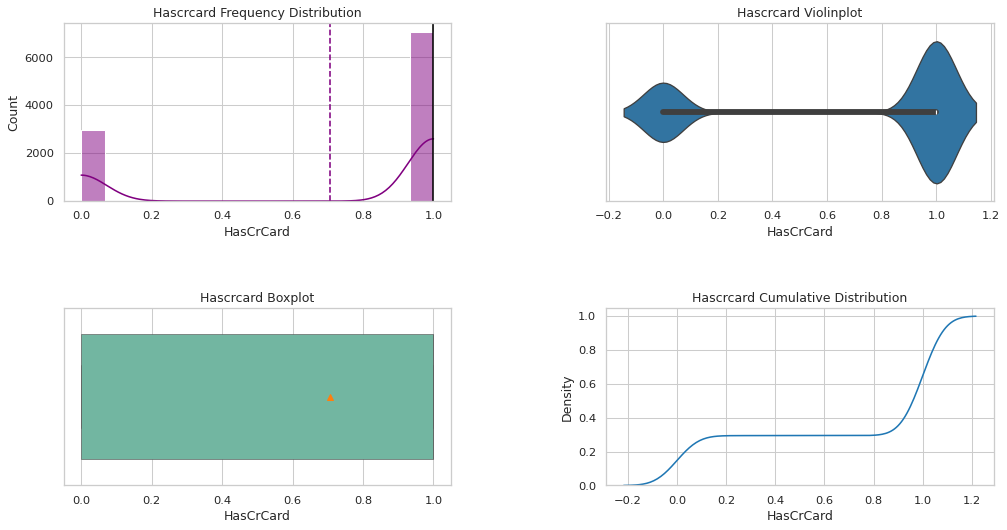




 Isactivemember 


,Min,Max,Q1,Q2,Q3,IQR,Mode,Skewness,Range,Unique,Non-Missing,Zeroes Count
Value,0,1,0.00,1.00,1.00,1.00,1,-0.06,1,2,10000,4849


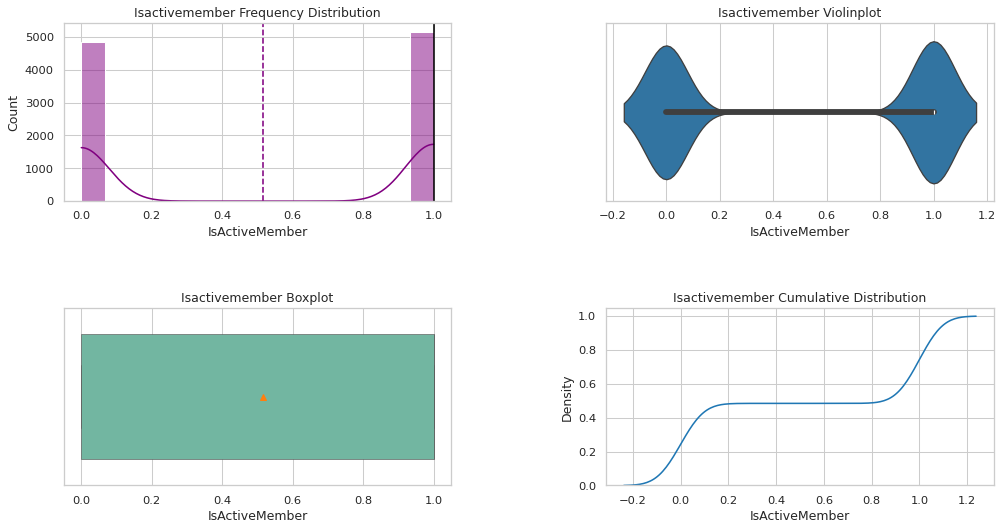




 Estimatedsalary 


,Min,Max,Q1,Q2,Q3,IQR,Mode,Skewness,Range,Unique,Non-Missing,Zeroes Count
Value,11.58,199992.48,51002.11,100193.91,149388.25,98386.14,24924.92,0.00,199980.90,9999,10000,0


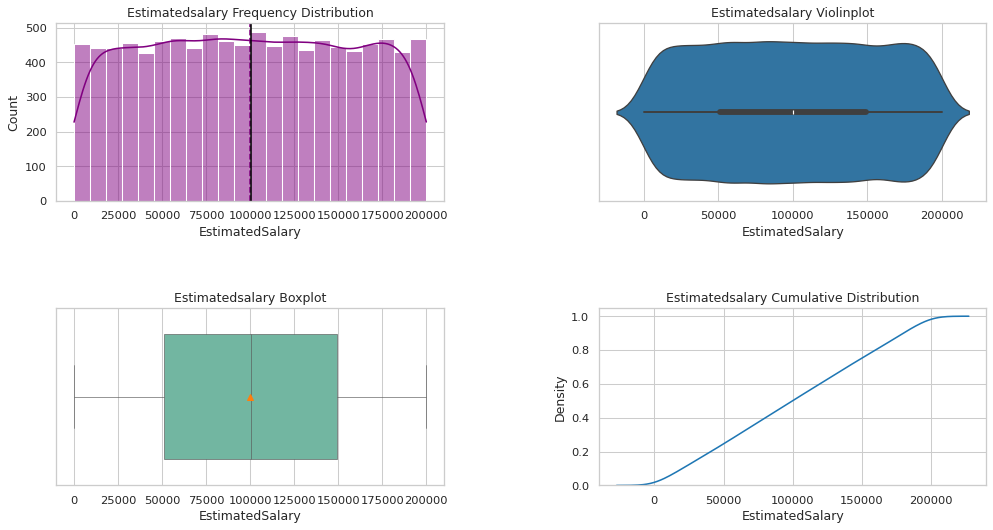




 Exited 


,Min,Max,Q1,Q2,Q3,IQR,Mode,Skewness,Range,Unique,Non-Missing,Zeroes Count
Value,0,1,0.00,0.00,0.00,0.00,0,1.47,1,2,10000,7963


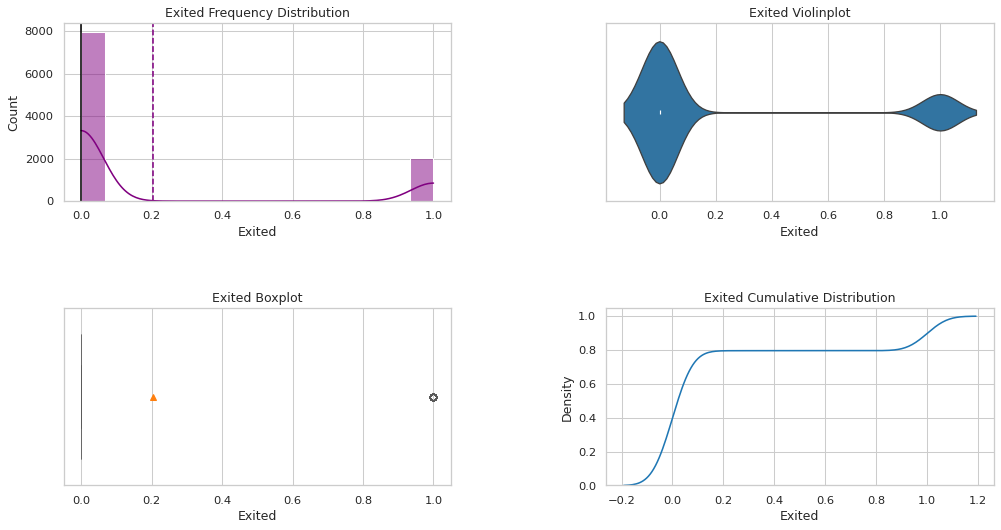

In [ ]:
# Show plots and statitics
for col in df.select_dtypes(include=np.number):
  print('\033[1m', col.title(),'\033[0m')
  create_plots(df, col)
  print('\n\n')

**Observations**

Credit Score:
- The credit score is normally distributed with a mode at 850, indicating many customers have excellent credit ratings.

Age:
- Age distribution is positively skewed, with a majority of customers being young, but also includes older customers, spanning from 18 to 92 years, with the majority between 32 and 44.

Tenure:
- Tenure shows a uniform distribution, with customer retention ranging from 0 to 10 years, and 413 customers having zero tenure, likely indicating new customers.

Balance:
- Balance distribution is slightly negatively skewed, with a concentration of lower balances and a significant number of customers (3617) having a zero balance, suggesting inactivity or recent account openings.

Number of Products:
- The distribution of the number of products is positively skewed, with most customers owning 1 product, a small interquartile range (IQR) of 1, and very few owning 4 products.

Has Credit Card:
- There is a negative skewness in the distribution of credit card ownership, with more customers owning a credit card than not, specifically 2945 customers do not own a credit card.

IsActiveMember:
- The distribution of active and non-active members is roughly even, with 4849 customers not active, indicating potential targets for engagement strategies.

Estimated Salary:
- Salaries are very uniformly distributed with zero skewness, covering a wide range, nearly the maximum possible value, and a large range with a substantial IQR, reflecting varied financial backgrounds.

Exited:
- The distribution is positively skewed, with most customers (7963 out of 10000) not having exited, indicating a minority has left the bank.

####**Categorical Univariate Plots**

In [ ]:
class CategoricalPlotter:
    def __init__(self, df):
        self.df = df
        self.categorical_columns = df.select_dtypes(include=['category']).columns.tolist()

    def plot_categorical_subplots(self):
        n_cols = 2
        n_rows = (len(self.categorical_columns) + n_cols - 1) // n_cols
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 8 * n_rows), dpi=75)
        fig.subplots_adjust(hspace=0.6, wspace=0.4)
        axes = axes.flatten()

        for i, col in enumerate(self.categorical_columns):
            ax = axes[i]
            sns.countplot(x=self.df[col], palette='Paired', ax=ax)
            ax.set_title(col)
            ax.tick_params(axis='x')

            total = len(self.df[col])  # total count for the column
            for p in ax.patches:
                percentage = '{:.1f}%'.format(100 * p.get_height() / total)
                ax.annotate(percentage, (p.get_x() + p.get_width() / 2., p.get_height()), # annotate the percantage
                            ha='center', va='bottom', size=10)

        # Deactivate remaining axes if any
        for j in range(i + 1, len(axes)):
            axes[j].set_visible(False)

        plt.tight_layout()
        plt.show()

In [ ]:
#instantiate the catplotter
catplotter = CategoricalPlotter(df)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   CreditScore      10000 non-null  int64   
 1   Geography        10000 non-null  category
 2   Gender           10000 non-null  category
 3   Age              10000 non-null  int64   
 4   Tenure           10000 non-null  int64   
 5   Balance          10000 non-null  float64 
 6   NumOfProducts    10000 non-null  int64   
 7   HasCrCard        10000 non-null  int64   
 8   IsActiveMember   10000 non-null  int64   
 9   EstimatedSalary  10000 non-null  float64 
 10  Exited           10000 non-null  int64   
dtypes: category(2), float64(2), int64(7)
memory usage: 723.0 KB


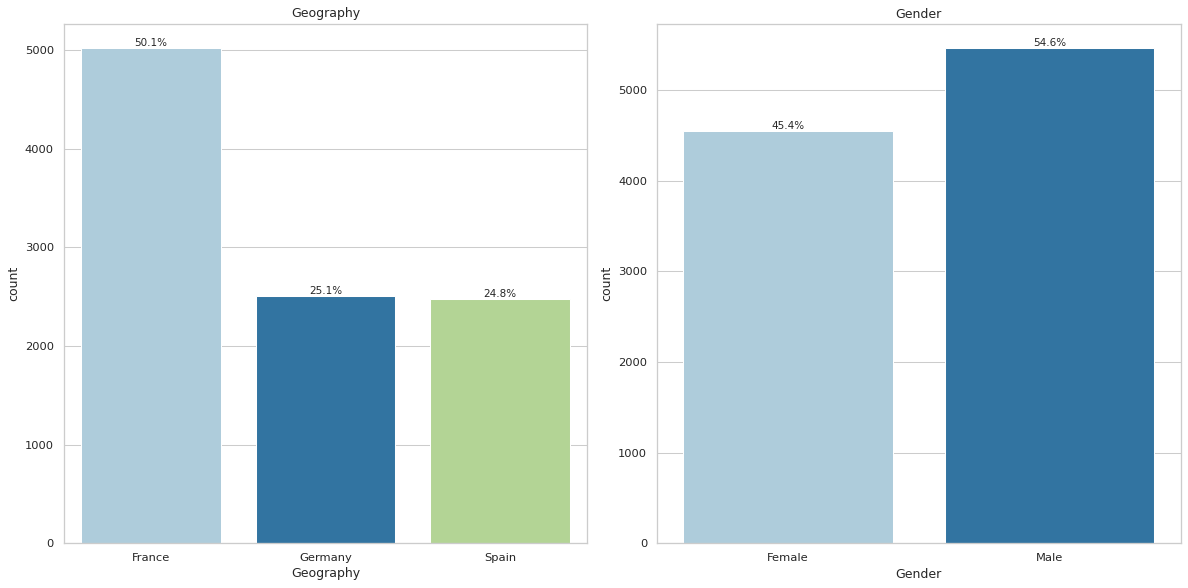

In [ ]:
#plot the categoricals
catplotter.plot_categorical_subplots()

**Observations**

Geography:
- France accounts for over half of the customers, with Germany and Spain each at a quarter, indicating a focus on France.

Gender:
- Males slightly outnumber females (54.6% to 45.4%).

### Bivariate Analysis

In [ ]:


def plot_compare_to_target(df, target_column='Exited', columns=None):
    if columns is None:
        # Select default columns to compare if none are provided, excluding the target and numeric columns
        columns = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember']
    num_plots = len(columns)
    fig, axes = plt.subplots(nrows=num_plots, ncols=1, figsize=(10, num_plots * 5))
    fig.tight_layout(pad=8.0)

    for i, col in enumerate(columns):
        if num_plots > 1:
            ax = axes[i]
        else:
            ax = axes  # When there's only one plot, axes is not an array

        # Plotting the count of categories based on Exited status
        sns.countplot(x=col, hue=target_column, data=df, ax=ax, palette='viridis')
        ax.set_title(f'Comparison of {col} to Customer Churn', fontsize=15)
        ax.set_xlabel(col, fontsize=12)
        ax.set_ylabel('Count', fontsize=12)
        ax.legend(title='Customer Churn', title_fontsize='13', fontsize='12', loc='upper right')

    plt.show()


def plot_influence_on_exited(df, exited_column='Exited', columns=None, figsize=(15, 10), cmap='gist_heat'):
    # Filter columns that are not the 'Exited' column and are numeric
    if columns is None:
        columns = [col for col in df.columns if col != exited_column and df[col].dtype != 'object']
    # Group data by 'Exited' status and calculate mean for each column
    grouped_data = df.groupby(exited_column)[columns].mean()
    # Plot the data
    grouped_data.plot(kind='bar', figsize=figsize, cmap=cmap)
    plt.title("Influence of Each Column on Customer Churn")
    plt.xlabel('Customer Churn')
    plt.ylabel('Average Value')
    plt.xticks(ticks=[0, 1], labels=['Not Exited', 'Exited'], rotation=0)  # Set x-tick labels
    plt.show()


def plot_distribution(df, x_column, hue_column):
        sns.displot(
        data=data,
        x=x_column,
        hue=hue_column,
        kind='kde'
    )

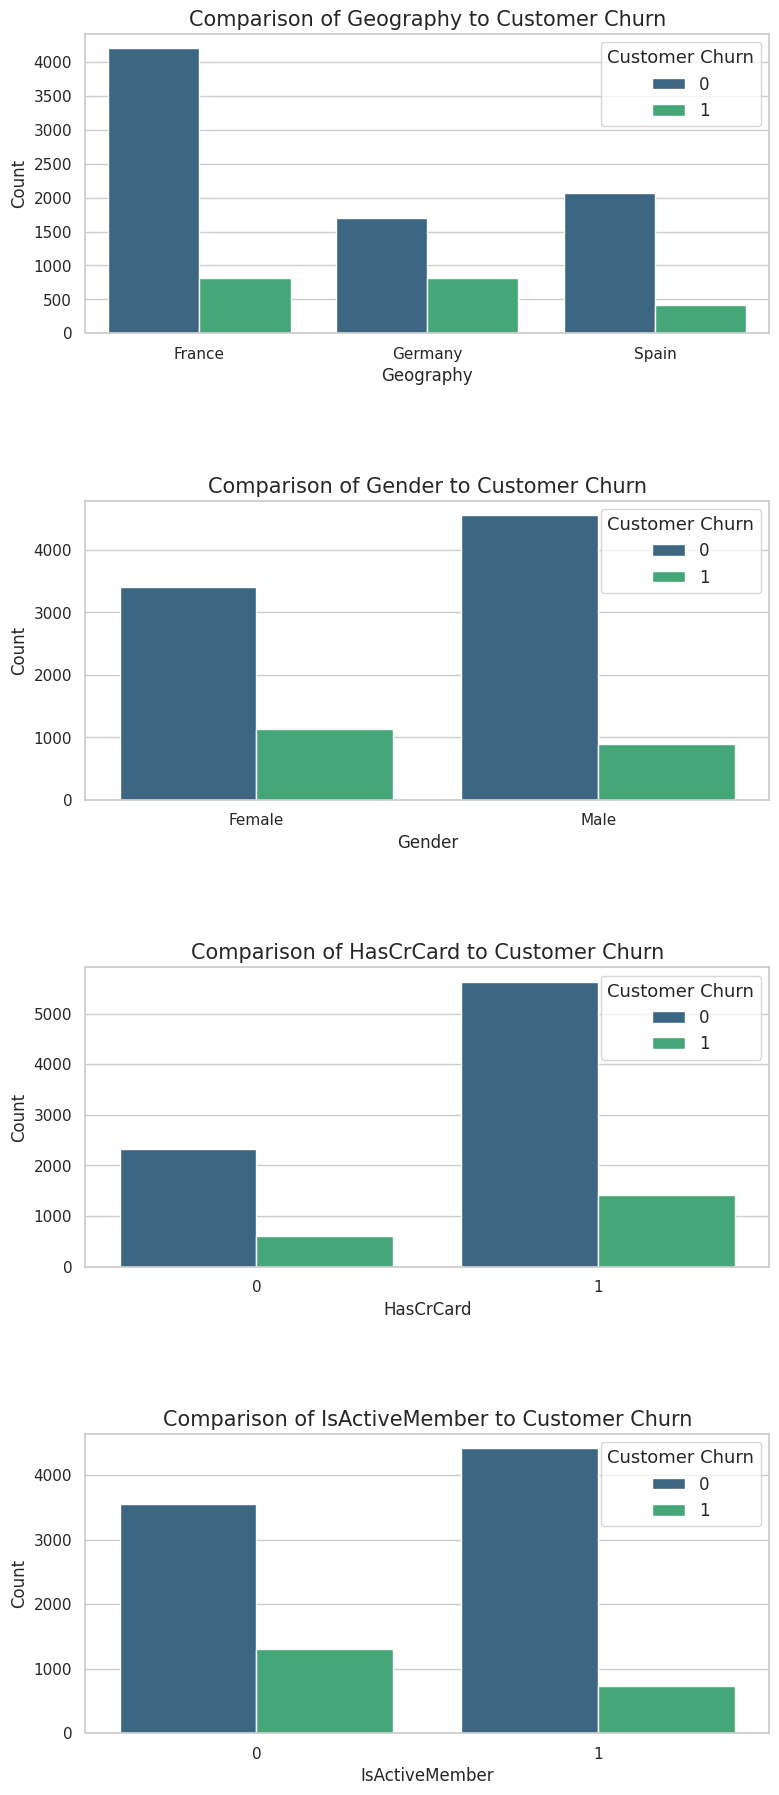

In [ ]:
plot_compare_to_target(df)

**Observations**

Geography:
- Germany has a higher churn rate than France and Spain, suggesting location-specific factors affect customer satisfaction.

Gender:
- Female customers have a higher churn rate than males, indicating gender-specific service satisfaction or needs.

Has Credit Card:
- Owning a credit card does not significantly affect churn rates, suggesting it's not a strong indicator of loyalty.

IsActiveMember:
- Inactive members have a higher churn rate than active members, highlighting the importance of engagement in retention.

####**Multi-Variate Analysis**

#####**Plot Functions**

In [ ]:
def plot_correlation_matrix():
    df_numeric = df.select_dtypes(include=[np.number])
    corr_matrix = df_numeric.corr()

    # Create a mask for the upper triangle
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

    sns.set_style('white')
    fig, ax = plt.subplots(figsize=(10, 10))
    sns.heatmap(corr_matrix, vmin=-1, vmax=1, cmap='Spectral', annot=True, mask=mask, linewidths=0, cbar_kws={"shrink": .5})
    plt.title('Correlation Matrix')
    plt.show()

def plot_pairs(df):
    plt.figure(figsize=(10,10), dpi=75)
    sns.set(palette='coolwarm')
    sns.pairplot(df, hue='Exited', markers=['o', 's', 'D'], corner=True)
    plt.title('Pair Plot')
    plt.show()

def plot_boxplots(df, cols):
    sns.set(style='white', palette='coolwarm')

    num_plots = len(cols)
    num_cols = 4
    num_rows = -(-num_plots // num_cols)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 3))
    axes = axes.flatten()

    for i, variable in enumerate(cols):
        ax = axes[i]
        sns.boxplot(x='Exited', y=variable, data=df, palette='PuBu', showmeans=True, ax=ax)
        ax.set_title(f'Exited vs {variable}')

    for j in range(i + 1, num_rows * num_cols):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()


#####**Correlation Matrix**

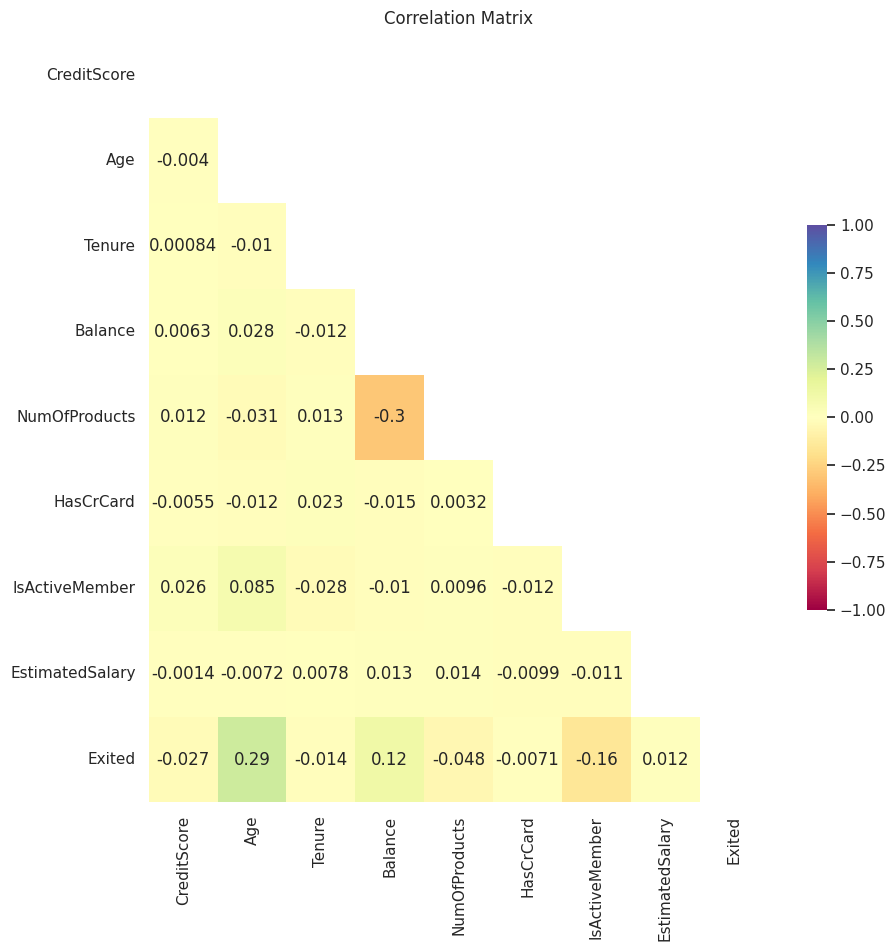

In [ ]:
plot_correlation_matrix()

**Observation**

- The number of products NumOfProducts moderately negatively correlates with churn Exited, indicating that customers with more products are less likely to leave the bank.

- Customer churn Exited slightly positively correlates with balance Balance, suggesting that customers with higher balances are more likely to churn.

- Being an active member IsActiveMember has a small negative correlation with churn Exited, indicating that active customers tend to stay with the bank.

- Other variables such as CreditScore, Age, Tenure, HasCrCard, and EstimatedSalary show very weak correlations with churn, suggesting they might not be strong predictors on their own.

##Outlier Detection

####**Define Outlier Functions**

In [ ]:
def plot_outliers_boxplots(df):

    num_data = df.select_dtypes(include=['float64', 'int64'])

    plt.figure(figsize=(15, 12))

    for i, variable in enumerate(num_data):
        plt.subplot(4, 4, i + 1)
        plt.boxplot(df[variable], whis=1.5)
        plt.title(variable)

    plt.tight_layout()
    plt.show()

def iqr_bounds(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

def outlier_percentages(df):
    outlier_results = []
    num_data = df.select_dtypes(include=['float64', 'int64'])

    for column in num_data.columns:
        Q1 = num_data[column].quantile(0.25)
        Q3 = num_data[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Calculate the percentage of outliers
        outliers = (num_data[column] < lower_bound) | (num_data[column] > upper_bound)
        outlier_percentage = outliers.sum() / len(num_data) * 100
        outlier_results.append({'Column': column, 'Outlier Percentage': outlier_percentage, 'Lower Bound':lower_bound, 'Upper Bound':upper_bound})


    outlier_frame = pd.DataFrame(outlier_results).sort_values(by='Outlier Percentage', ascending=False)

    return outlier_frame

####**Plot Outliers**

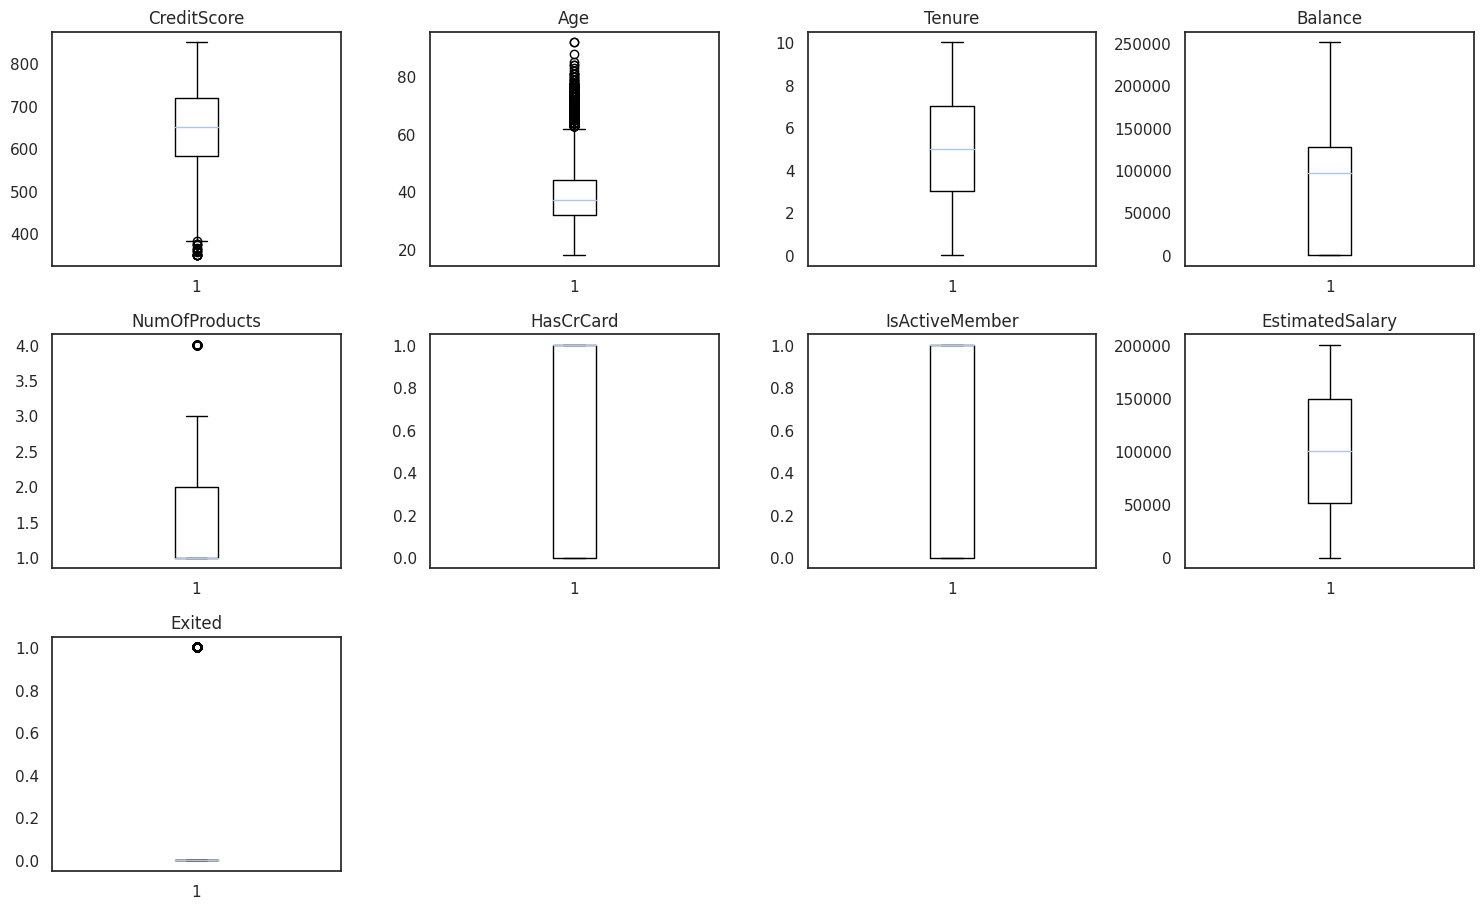

In [ ]:
plot_outliers_boxplots(df)

**Observation**

- Credit Score: The distribution is tight, with no significant outliers, indicating most customers have a credit score within a narrow range.

- Age: The distribution has a wider range with outliers in the upper age bracket, suggesting a smaller number of older customers.

- Tenure: Customers are spread across a range of tenure lengths with no extreme outliers, indicating a fairly even distribution.

- Balance: There's a wide distribution with a few outliers, indicating some customers with significantly high balances.

- NumOfProducts: Most customers have 1 or 2 products, with outliers having more than 2 products, which are rare.

- HasCrCard: The majority of customers have a credit card from the bank, with only two distinct values.

- IsActiveMember: There's an almost equal distribution of active and inactive members, with only two distinct values.

- Estimated Salary: Salaries are widely distributed with no significant outliers, indicating variation in income levels.

- Exited: It's a binary variable showing imbalance with more customers not having exited compared to those who have.

####**Percentage Outliers**

In [ ]:
outlier_table = outlier_percentages(df)
print(outlier_table)

            Column  Outlier Percentage  Lower Bound  Upper Bound
8           Exited               20.37         0.00         0.00
1              Age                3.59        14.00        62.00
4    NumOfProducts                0.60        -0.50         3.50
0      CreditScore                0.15       383.00       919.00
2           Tenure                0.00        -3.00        13.00
3          Balance                0.00   -191466.36    319110.60
5        HasCrCard                0.00        -1.50         2.50
6   IsActiveMember                0.00        -1.50         2.50
7  EstimatedSalary                0.00    -96577.10    296967.45


## Data Preprocessing

### Train-validation-test Split

In [ ]:
# Create copy as a check point to come back to
df_model = df.copy()

In [ ]:
# seperationg features and target column
X = df_model.drop(['Exited'], axis=1)
y = df_model['Exited']

In [ ]:
# Split the data into training 80% and a temp set 20%

X_large, X_test, y_large, y_test = train_test_split(X, y, test_size=0.20, random_state = 42, stratify=y, shuffle = True)

# Splitting the dataset into the Training and Testing set.

X_train, X_val, y_train, y_val = train_test_split(X_large, y_large, test_size=0.20, random_state = 42, stratify=y_large, shuffle = True)

In [ ]:
print(X_train.shape, X_val.shape, X_test.shape)


(6400, 10) (1600, 10) (2000, 10)


- We have 6400 observations in the train set, 1600 in the validation set, and
 2000 in test.

In [ ]:
df_model.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


### Dummy Variable Creation

In [ ]:
def encode_columns(dframe):
    return pd.get_dummies(dframe, columns=["Geography", "Gender"], drop_first=True)

def standard_scale_datasets(train_data, val_data, test_data, columns):
    sc = StandardScaler()
    train_data[columns] = sc.fit_transform(train_data[columns])
    val_data[columns] = sc.transform(val_data[columns])
    test_data[columns] = sc.transform(test_data[columns])

    return train_data, val_data, test_data

def print_null_values(*dataframes):
    for i, dframe in enumerate(dataframes, start=1):
        print(f"DataFrame {i} Null Value Counts:")
        print(dframe.isna().sum())
        print('-' * 40)

def create_dummies(X_train, X_val, X_test):
    # convert training data to dummies
    X_train_dummies = pd.get_dummies(X_train, drop_first=True)

    # convert validation and test data to dummies
    X_val_dummies = pd.get_dummies(X_val, drop_first=True)
    X_test_dummies = pd.get_dummies(X_test, drop_first=True)

    print(X_train_dummies.shape, X_val_dummies.shape, X_test_dummies.shape)

    return X_train_dummies, X_val_dummies, X_test_dummies

In [ ]:
#check for null values
print_null_values(X_train, X_val, X_test)

DataFrame 1 Null Value Counts:
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
dtype: int64
----------------------------------------
DataFrame 2 Null Value Counts:
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
dtype: int64
----------------------------------------
DataFrame 3 Null Value Counts:
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
dtype: int64
----------------------------------------


In [ ]:
# Encoding 'Geography' and 'Gender' variables in the training, test, and validation sets
X_train, X_val, X_test = create_dummies(X_train, X_val, X_test)


(6400, 11) (1600, 11) (2000, 11)


### Data Normalization

In [ ]:
# To ensure consistency across numerical values, we will scale them to a common scale.
# Apply standard scaling to specified columns of the train, validation, and test sets.
col_list = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']
X_train, X_val, X_test = standard_scale_datasets(X_train, X_val, X_test, col_list)


## Model Building

### Model Evaluation Criterion

In the context of predicting customer churn at a bank, it is usually more important and expensive to keep customers than it is to mistakenly identify loyal customers for retention efforts.

Therefore, the primary metric that often comes up is Recall. However, in order to avoid spending too much on unnecessary interventions, it is equally important to have a good level of Precision.

This is where the F1 Score comes in handy as it effectively balances both precision and recall.


In [ ]:
print(X_train.dtypes)


CreditScore          float64
Age                  float64
Tenure               float64
Balance              float64
NumOfProducts          int64
HasCrCard              int64
IsActiveMember         int64
EstimatedSalary      float64
Geography_Germany       bool
Geography_Spain         bool
Gender_Male             bool
dtype: object


In [ ]:
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
y_train = y_train.astype('float32')
y_val = y_val.astype('float32')

In [ ]:
# Initialize blank DataFrames to store recall values for all models
train_metrics_df = pd.DataFrame(columns=['recall'])
valid_metrics_df = pd.DataFrame(columns=['recall'])

### Utility functions

In [ ]:
def make_confusion_matrix(actual_targets, predicted_targets, count=True, percent=True, title='Confusion Matrix'):

    cm = confusion_matrix(actual_targets, predicted_targets)
    cm = cm.astype('float')

    label_names = ['True Positive','False Negative','False Positive','True Negative']

    # Ensure actual_targets and predicted_targets are 1D arrays
    if isinstance(actual_targets, pd.DataFrame):
        actual_targets = actual_targets.iloc[:, 0]
    if isinstance(predicted_targets, pd.DataFrame):
        predicted_targets = predicted_targets.iloc[:, 0]

    blanks = ['' for i in range(cm.size)]

    if label_names and len(label_names)==cm.size:
        group_labels = ["{}\n".format(value) for value in label_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cm.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cm.shape[0],cm.shape[1])

    sns.heatmap(cm, annot=box_labels,fmt="",cmap='Blues', cbar=False, xticklabels=['Non Churn','Churn'], yticklabels=['Non Churn','Churn'])

    plt.title(title)
    plt.show()



In [ ]:
def plot_loss(history):
    # Use a style for the plot
    plt.style.use('ggplot')

    # Plot the training and validation loss
    plt.plot(history.history['loss'], label='Train', linewidth=2, marker='o')
    plt.plot(history.history['val_loss'], label='Validation', linewidth=2, marker='o')

    # Set a grid
    plt.grid(True, linestyle='--', alpha=0.5)

    # Set the title and labels
    plt.title('Model Loss', fontsize=14)
    plt.ylabel('Loss', fontsize=12)
    plt.xlabel('Epoch', fontsize=12)

    # Adjust the legend
    plt.legend(loc='upper right', fontsize=10)

    # Show the plot
    plt.show()

In [ ]:
def plot_hist_recall(history):
    # Use a style for the plot
    plt.style.use('ggplot')

    # Plot the training and validation recall
    plt.plot(history.history['recall'], label='Train', linewidth=2, marker='o')
    plt.plot(history.history['val_recall'], label='Validation', linewidth=2, marker='o')

    # Set a grid
    plt.grid(True, linestyle='--', alpha=0.5)

    # Set the title and labels
    plt.title('Model Recall', fontsize=14)
    plt.ylabel('Recall', fontsize=12)
    plt.xlabel('Epoch', fontsize=12)

    # Adjust the legend
    plt.legend(loc='upper right', fontsize=10)

    # Show the plot
    plt.show()

In [ ]:
def print_classification_report(y_true, y_pred, model_name=None, title='Classification Report'):
    # Generate the classification report
    report = classification_report(y_true, y_pred, output_dict=True)

    # Convert the report to a DataFrame
    report_df = pd.DataFrame(report).transpose()

    # Print the title and model name
    print(f"\n{title}\n{'-' * len(title)}\nModel: {model_name}\n")

    # Print the DataFrame
    print(report_df)

    # Add a separator for clarity
    print("\n" + '-' * 80 + "\n")

In [ ]:
def clear_backends_set_seeds():
    seed_value = 2
    backend.clear_session() # Clear the TensorFlow backend session
    np.random.seed(seed_value) # Set seed for NumPy
    random.seed(seed_value) # Set seed for Python's random module
    tf.random.set_seed(seed_value) # Set seed for TensorFlow

### Model 0: **Neural Network with SGD Optimizer**

In [ ]:
clear_backends_set_seeds()

In [ ]:
def initialize_model_0(input_dim):
    # Create a Sequential model
    model = Sequential()

    # Input layer and first hidden layer
    model.add(Dense(64, activation='relu', input_dim=input_dim))

    # Adding a second hidden layer
    model.add(Dense(32, activation='relu'))

    # Output layer with a single neuron
    model.add(Dense(1, activation='sigmoid'))

    # Define the optimizer and metric
    optimizer = keras.optimizers.SGD(learning_rate=0.001)
    metric = keras.metrics.Recall()

    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[metric])

    # Print the model summary
    model.summary()

    return model

In [ ]:
# Assuming X_train is defined somewhere in your code
input_dim = X_train.shape[1]
model_0 = initialize_model_0(input_dim)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                768       
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2881 (11.25 KB)
Trainable params: 2881 (11.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Fitting the ANN
history_0 = model_0.fit(X_train, y_train, batch_size=32, validation_data=(X_val, y_val), epochs=100, verbose=1)

In [ ]:
#Plotting Train Loss vs Validation Loss
plot_loss(history_0)

**Recall**

In [ ]:
#Predicting the results using best as a threshold
y_train_pred = model_0.predict(X_train)
y_train_pred = (y_train_pred > 0.5)
y_train_pred

200/200 [==============================] - 0s 2ms/step


array([[False],
       [False],
       [False],
       ...,
       [False],
       [False],
       [False]])

In [ ]:
# Predicting the results using 0.5 as a threshold
y_val_pred = model_0.predict(X_val)  # Fill in with X_val to make prediction on the validation set
y_val_pred = (y_val_pred > 0.5)  # Applying threshold to convert probabilities to binary output
y_val_pred


50/50 [==============================] - 0s 2ms/step


array([[False],
       [False],
       [False],
       ...,
       [False],
       [False],
       [False]])

In [ ]:
model_name = 'NN with SGD'

train_metrics_df.loc[model_name] = recall_score(y_train, y_train_pred)
valid_metrics_df.loc[model_name] = recall_score(y_val, y_val_pred)

In [ ]:
print_classification_report(y_train, y_train_pred, model_name, title='Training Set Classification Report')


Training Set Classification Report
----------------------------------
Model: NN with SGD

              precision  recall  f1-score  support
0.0                0.83    0.97      0.90  5096.00
1.0                0.67    0.23      0.34  1304.00
accuracy           0.82    0.82      0.82     0.82
macro avg          0.75    0.60      0.62  6400.00
weighted avg       0.80    0.82      0.78  6400.00

--------------------------------------------------------------------------------



In [ ]:
print_classification_report(y_val, y_val_pred, model_name, title='Validation Set Classification Report')


Validation Set Classification Report
------------------------------------
Model: NN with SGD

              precision  recall  f1-score  support
0.0                0.82    0.97      0.89  1274.00
1.0                0.61    0.17      0.27   326.00
accuracy           0.81    0.81      0.81     0.81
macro avg          0.71    0.57      0.58  1600.00
weighted avg       0.78    0.81      0.76  1600.00

--------------------------------------------------------------------------------



**Confusion matrix**

In [ ]:
make_confusion_matrix(y_train, y_train_pred)


In [ ]:
make_confusion_matrix(y_val, y_val_pred)

## Model Performance Improvement

### Model 1: **Neural Network with Adam Optimizer**

In [ ]:
def initialize_model_1(input_dim):
    clear_backends_set_seeds()

    model = Sequential()

    model.add(Dense(128, activation='relu', input_dim=input_dim))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    optimizer = keras.optimizers.Adam(learning_rate=0.001)
    metric = Recall()

    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[metric])
    model.summary()

    return model

In [ ]:
model_1 = initialize_model_1(X_train.shape[1])

In [ ]:
# Fitting the ANN
history_1 = model_1.fit(X_train, y_train, batch_size=32, validation_data=(X_val, y_val), epochs=100)

**Loss Function**

In [ ]:
#Plotting Train Loss vs Validation Loss
plot_loss(history_1)


**Recall**

In [ ]:
plot_hist_recall(history_1)

In [ ]:
#Predicting the results using 0.5 as the threshold
y_train_pred = model_1.predict(X_train)
y_train_pred = (y_train_pred > 0.5)
y_train_pred

200/200 [==============================] - 0s 2ms/step


array([[ True],
       [False],
       [False],
       ...,
       [False],
       [ True],
       [False]])

In [ ]:
#Predicting the results using 0.5 as the threshold
y_val_pred = model_1.predict(X_val)
y_val_pred = (y_val_pred > 0.5)
y_val_pred

50/50 [==============================] - 0s 2ms/step


array([[False],
       [False],
       [False],
       ...,
       [False],
       [False],
       [ True]])

In [ ]:
model_name = "NN with Adam"

train_metrics_df.loc[model_name] = recall_score(y_train,y_train_pred)
valid_metrics_df.loc[model_name] = recall_score(y_val,y_val_pred)

**Classification Report**

In [ ]:
print_classification_report(y_train, y_train_pred, model_name, title='Training Set Classification Report')


Training Set Classification Report
----------------------------------
Model: NN with Adam

              precision  recall  f1-score  support
0.0                0.96    0.99      0.97  5096.00
1.0                0.94    0.84      0.89  1304.00
accuracy           0.96    0.96      0.96     0.96
macro avg          0.95    0.91      0.93  6400.00
weighted avg       0.96    0.96      0.96  6400.00

--------------------------------------------------------------------------------



In [ ]:
print_classification_report(y_val, y_val_pred, model_name, title='Validation Set Classification Report')


Validation Set Classification Report
------------------------------------
Model: NN with Adam

              precision  recall  f1-score  support
0.0                0.87    0.92      0.90  1274.00
1.0                0.61    0.47      0.53   326.00
accuracy           0.83    0.83      0.83     0.83
macro avg          0.74    0.70      0.72  1600.00
weighted avg       0.82    0.83      0.82  1600.00

--------------------------------------------------------------------------------



**Confusion Matrix**

In [ ]:
#Calculating the confusion matrix
make_confusion_matrix(y_train, y_train_pred, title="Training Confusion Matrix")

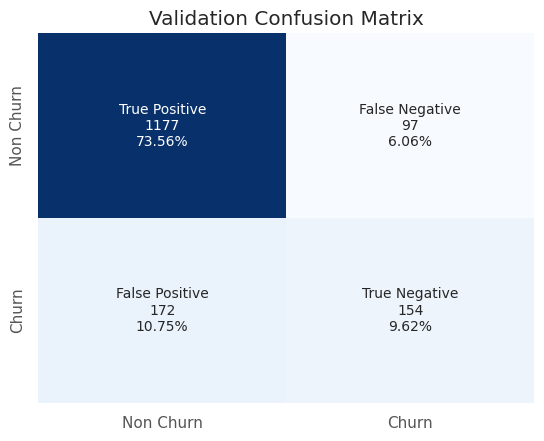

In [ ]:
make_confusion_matrix(y_val, y_val_pred, title="Validation Confusion Matrix")

### Model 2: **Neural Network with Adam Optimizer and Dropout**

In [ ]:
def initialize_model_2(input_dim):
    clear_backends_set_seeds()

    model = Sequential()

    model.add(Dense(128, activation='relu', input_dim=input_dim))
    model.add(Dropout(0.2))

    model.add(Dense(64, activation='relu'))

    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.1))

    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    optimizer = keras.optimizers.Adam(learning_rate=0.001)
    metric = keras.metrics.Recall()

    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[metric])
    model.summary()

    return model

In [ ]:
model_2 = initialize_model_2(X_train.shape[1])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1536      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 32)                1056      
                                                                 
 dense_4 (Dense)             (None, 1)                 3

In [ ]:
history_2 = model_2.fit(X_train, y_train, batch_size=32, validation_data=(X_val, y_val), epochs=100)


Epoch 1/100
200/200 [==============================] - 2s 5ms/step - loss: 0.4667 - recall: 0.0337 - val_loss: 0.4290 - val_recall: 0.0982
Epoch 2/100
200/200 [==============================] - 1s 5ms/step - loss: 0.4193 - recall: 0.2646 - val_loss: 0.4133 - val_recall: 0.2485
Epoch 3/100
200/200 [==============================] - 1s 6ms/step - loss: 0.4030 - recall: 0.3351 - val_loss: 0.4021 - val_recall: 0.2822
Epoch 4/100
200/200 [==============================] - 1s 6ms/step - loss: 0.3950 - recall: 0.3390 - val_loss: 0.3968 - val_recall: 0.3957
Epoch 5/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3818 - recall: 0.3773 - val_loss: 0.3901 - val_recall: 0.2699
Epoch 6/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3729 - recall: 0.3919 - val_loss: 0.3727 - val_recall: 0.4448
Epoch 7/100
200/200 [==============================] - 1s 4ms/step - loss: 0.3632 - recall: 0.4279 - val_loss: 0.3664 - val_recall: 0.3282
Epoch 8/100
200/200 [======

**Loss Function**

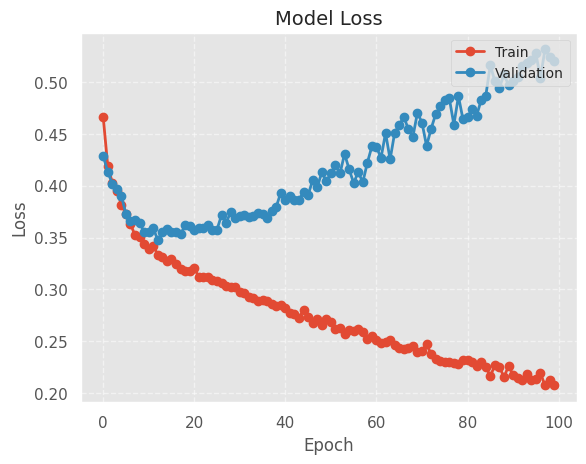

In [ ]:
#Plotting Train Loss vs Validation Loss
plot_loss(history_2)

**Recall**



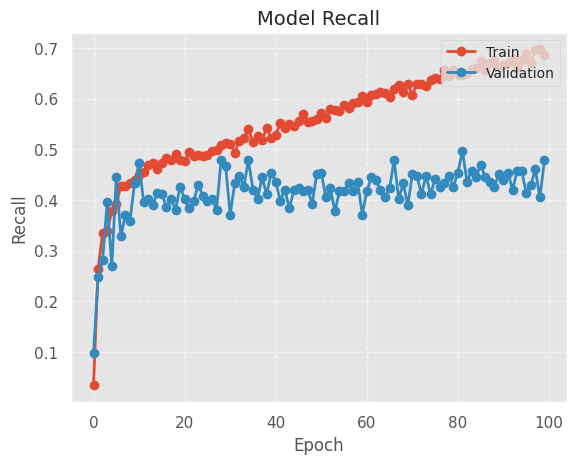

In [ ]:
plot_hist_recall(history_2)

In [ ]:
#Predicting the results using 0.5 as the threshold.
y_val_pred = model_2.predict(X_val)
y_val_pred = (y_val_pred > 0.5)
y_val_pred

50/50 [==============================] - 0s 2ms/step


array([[False],
       [False],
       [False],
       ...,
       [False],
       [False],
       [ True]])

In [ ]:
model_name = "NN with Adam & Dropout"

train_metrics_df.loc[model_name] = recall_score(y_train,y_train_pred)
valid_metrics_df.loc[model_name] = recall_score(y_val,y_val_pred)

**Classification Report**


In [ ]:
print_classification_report(y_train, y_train_pred, model_name, title='Training Set Classification Report')


Training Set Classification Report
----------------------------------
Model: NN with Adam & Dropout

              precision  recall  f1-score  support
0.0                0.96    0.99      0.97  5096.00
1.0                0.94    0.84      0.89  1304.00
accuracy           0.96    0.96      0.96     0.96
macro avg          0.95    0.91      0.93  6400.00
weighted avg       0.96    0.96      0.96  6400.00

--------------------------------------------------------------------------------



In [ ]:
print_classification_report(y_val, y_val_pred, model_name, title='Validation Set Classification Report')


Validation Set Classification Report
------------------------------------
Model: NN with Adam & Dropout

              precision  recall  f1-score  support
0.0                0.87    0.92      0.89  1274.00
1.0                0.60    0.48      0.53   326.00
accuracy           0.83    0.83      0.83     0.83
macro avg          0.73    0.70      0.71  1600.00
weighted avg       0.82    0.83      0.82  1600.00

--------------------------------------------------------------------------------



**Confusion Matrix**

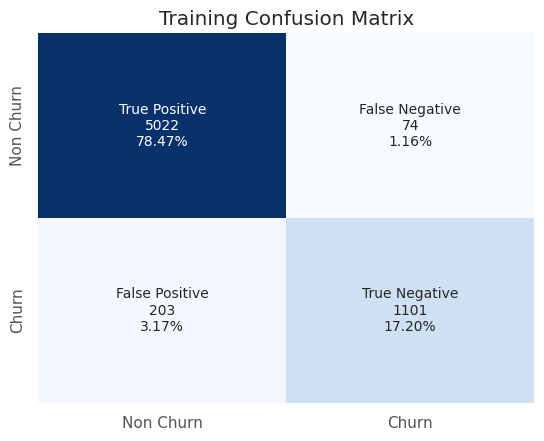

In [ ]:
make_confusion_matrix(y_train, y_train_pred, title="Training Confusion Matrix")

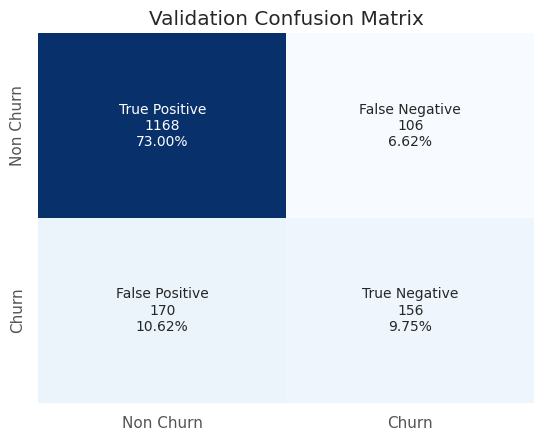

In [ ]:
make_confusion_matrix(y_val, y_val_pred, title="Validation Confusion Matrix")


### Model 3: **Neural Network with Balanced Data (by applying SMOTE) and SGD Optimizer**

In [ ]:
sm = SMOTE(random_state=42)
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)
print('After UpSampling, the shape of train_X: {}'.format(X_train_smote.shape))
print('After UpSampling, the shape of train_y: {} \n'.format(y_train_smote.shape))

After UpSampling, the shape of train_X: (10192, 11)
After UpSampling, the shape of train_y: (10192,) 



In [ ]:
clear_backends_set_seeds()

In [ ]:
def initialize_model_3(input_dim):
    model = Sequential()

    # Adding the input layer
    model.add(Dense(128, activation='relu', input_dim=input_dim))

    # Adding a hidden layer
    model.add(Dense(64, activation='relu'))

    # Adding another hidden layer
    model.add(Dense(32, activation='relu'))

    # Adding the output layer
    model.add(Dense(1, activation='sigmoid'))

    optimizer = keras.optimizers.SGD(learning_rate=0.001)
    metric = keras.metrics.Recall()

    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[metric])

    model.summary()

    return model

In [ ]:
model_3 = initialize_model_3(X_train_smote.shape[1])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1536      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 11905 (46.50 KB)
Trainable params: 11905 (46.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
history_3 = model_3.fit(X_train_smote, y_train_smote, batch_size=32, epochs=100, validation_data=(X_val, y_val))

**Loss Function**

In [ ]:
#Plotting Train Loss vs Validation Loss
plot_loss(history_3)


**Recall**


In [ ]:
plot_hist_recall(history_3)

In [ ]:
y_train_pred = model_3.predict(X_train_smote)
#Predicting the results using 0.5 as the threshold
y_train_pred = (y_train_pred > 0.5)
y_train_pred

319/319 [==============================] - 1s 2ms/step


array([[ True],
       [False],
       [False],
       ...,
       [ True],
       [ True],
       [ True]])

In [ ]:
y_val_pred = model_3.predict(X_val)
#Predicting the results using 0.5 as the threshold
y_val_pred = (y_val_pred > 0.5)
y_val_pred

50/50 [==============================] - 0s 2ms/step


array([[False],
       [False],
       [False],
       ...,
       [False],
       [ True],
       [ True]])

In [ ]:
model_name = "NN with SMOTE & SGD"

train_metrics_df.loc[model_name] = recall_score(y_train_smote,y_train_pred)
valid_metrics_df.loc[model_name] = recall_score(y_val,y_val_pred)

**Classification Report**


In [ ]:
print_classification_report(y_train_smote, y_train_pred, model_name, title='Training Set Classification Report')


Training Set Classification Report
----------------------------------
Model: NN with SMOTE & SGD

              precision  recall  f1-score  support
0.0                0.75    0.76      0.76  5096.00
1.0                0.76    0.75      0.76  5096.00
accuracy           0.76    0.76      0.76     0.76
macro avg          0.76    0.76      0.76 10192.00
weighted avg       0.76    0.76      0.76 10192.00

--------------------------------------------------------------------------------



In [ ]:
print_classification_report(y_val, y_val_pred, model_name, title='Validation Set Classification Report')


Validation Set Classification Report
------------------------------------
Model: NN with SMOTE & SGD

              precision  recall  f1-score  support
0.0                0.90    0.75      0.82  1274.00
1.0                0.41    0.68      0.51   326.00
accuracy           0.73    0.73      0.73     0.73
macro avg          0.65    0.71      0.66  1600.00
weighted avg       0.80    0.73      0.75  1600.00

--------------------------------------------------------------------------------



**Confusion Matrix**

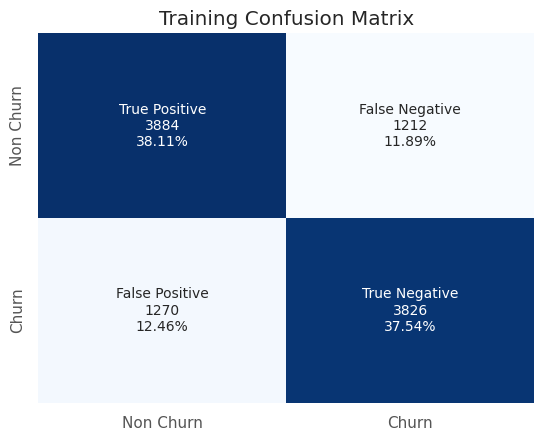

In [ ]:
make_confusion_matrix(y_train_smote, y_train_pred, title="Training Confusion Matrix")

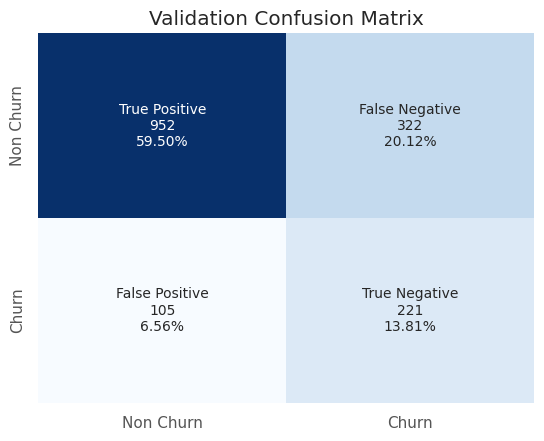

In [ ]:
make_confusion_matrix(y_val, y_val_pred, title="Validation Confusion Matrix")

### Model 4: **Neural Network with Balanced Data (by applying SMOTE) and Adam Optimizer**

In [ ]:
clear_backends_set_seeds()

In [ ]:
def initialize_model_4(input_dim):

    model = Sequential()

    # Add an input layer
    model.add(Dense(128, activation='relu', input_dim=input_dim))

    # Add a hidden layer
    model.add(Dense(64, activation='relu'))

    # Add a hidden layer
    model.add(Dense(32, activation='relu'))

    # Add an output layer
    model.add(Dense(1, activation='sigmoid'))

    optimizer = keras.optimizers.Adam(learning_rate=0.001)

    metric = keras.metrics.Recall()

    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[metric])

    model.summary()

    return model



In [ ]:
model_4 = initialize_model_4(X_train_smote.shape[1])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1536      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 11905 (46.50 KB)
Trainable params: 11905 (46.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
#Fitting the ANN
history_4 = model_4.fit(X_train_smote, y_train_smote, batch_size=32, epochs=100, validation_data=(X_val, y_val))

**Loss Function**

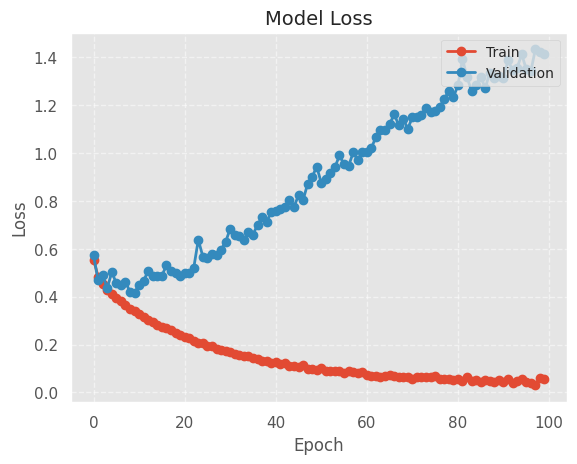

In [ ]:
plot_loss(history_4)

**Recall**

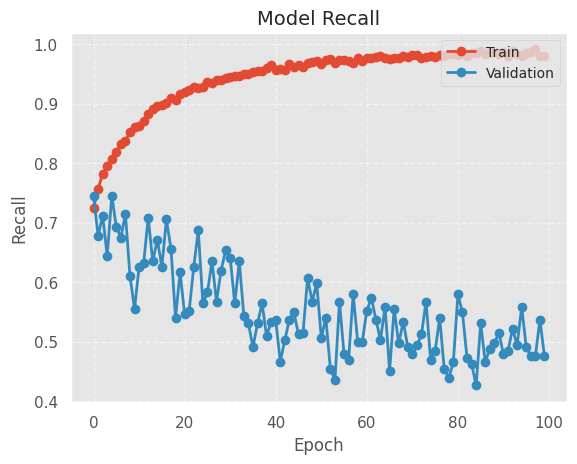

In [ ]:
plot_hist_recall(history_4)

In [ ]:
y_train_pred = model_4.predict(X_train_smote)
#Predicting the results using 0.5 as the threshold
y_train_pred = (y_train_pred > 0.5)
y_train_pred

319/319 [==============================] - 1s 2ms/step


array([[ True],
       [False],
       [False],
       ...,
       [ True],
       [ True],
       [ True]])

In [ ]:
y_val_pred = model_4.predict(X_val)
#Predicting the results using 0.5 as the threshold
y_val_pred = (y_val_pred > 0.5)
y_val_pred

50/50 [==============================] - 0s 2ms/step


array([[ True],
       [False],
       [False],
       ...,
       [False],
       [ True],
       [ True]])

In [ ]:
model_name = "NN with SMOTE & Adam"

train_metrics_df.loc[model_name] = recall_score(y_train_smote,y_train_pred)
valid_metrics_df.loc[model_name] = recall_score(y_val,y_val_pred)

**Classification Report**

In [ ]:
print_classification_report(y_train_smote, y_train_pred, model_name, title='Training Set Classification Report')


Training Set Classification Report
----------------------------------
Model: NN with SMOTE & Adam

              precision  recall  f1-score  support
0.0                0.99    0.99      0.99  5096.00
1.0                0.99    0.99      0.99  5096.00
accuracy           0.99    0.99      0.99     0.99
macro avg          0.99    0.99      0.99 10192.00
weighted avg       0.99    0.99      0.99 10192.00

--------------------------------------------------------------------------------



In [ ]:
print_classification_report(y_val, y_val_pred, model_name, title='Validation Set Classification Report')


Validation Set Classification Report
------------------------------------
Model: NN with SMOTE & Adam

              precision  recall  f1-score  support
0.0                0.87    0.89      0.88  1274.00
1.0                0.53    0.48      0.50   326.00
accuracy           0.81    0.81      0.81     0.81
macro avg          0.70    0.68      0.69  1600.00
weighted avg       0.80    0.81      0.80  1600.00

--------------------------------------------------------------------------------



**Confusion matrix**

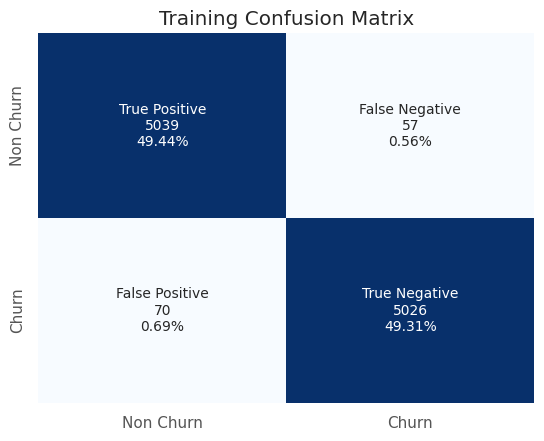

In [ ]:
make_confusion_matrix(y_train_smote, y_train_pred, title="Training Confusion Matrix")

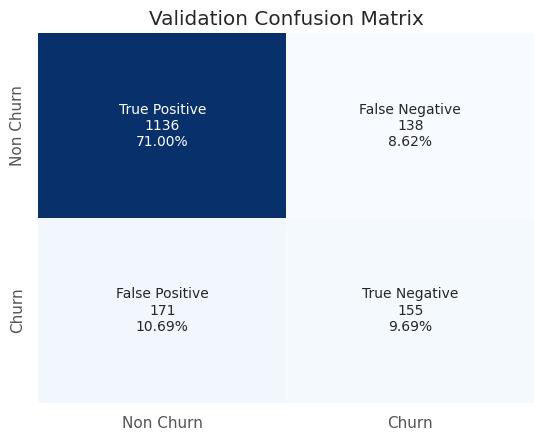

In [ ]:
make_confusion_matrix(y_val, y_val_pred, title="Validation Confusion Matrix")

### Model 5: **Neural Network with Balanced Data (by applying SMOTE), Adam Optimizer, and Dropout**

In [ ]:
clear_backends_set_seeds()

In [ ]:
def initialize_model_5(input_dim):
    model = Sequential()
    model.add(Dense(64, activation='relu', input_dim=input_dim))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    optimizer = keras.optimizers.Adam(0.001)
    metric = keras.metrics.Recall()

    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[metric])

    model.summary()

    return model

In [ ]:
model_5 = initialize_model_5(X_train_smote.shape[1])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                768       
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 8)                 264       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 3121 (12.19 KB)
Trainable params: 3121 (12

In [ ]:
history_5 = model_5.fit(X_train_smote, y_train_smote, batch_size=32, epochs=100, validation_data=(X_val, y_val))

Epoch 1/100
319/319 [==============================] - 4s 7ms/step - loss: 0.6058 - recall: 0.7062 - val_loss: 0.5621 - val_recall: 0.6779
Epoch 2/100
319/319 [==============================] - 1s 4ms/step - loss: 0.5583 - recall: 0.7286 - val_loss: 0.5409 - val_recall: 0.6718
Epoch 3/100
319/319 [==============================] - 1s 4ms/step - loss: 0.5389 - recall: 0.7253 - val_loss: 0.5133 - val_recall: 0.6564
Epoch 4/100
319/319 [==============================] - 1s 4ms/step - loss: 0.5222 - recall: 0.7467 - val_loss: 0.4951 - val_recall: 0.6687
Epoch 5/100
319/319 [==============================] - 1s 4ms/step - loss: 0.5057 - recall: 0.7514 - val_loss: 0.4940 - val_recall: 0.6994
Epoch 6/100
319/319 [==============================] - 1s 4ms/step - loss: 0.4958 - recall: 0.7531 - val_loss: 0.4798 - val_recall: 0.6963
Epoch 7/100
319/319 [==============================] - 1s 4ms/step - loss: 0.4815 - recall: 0.7594 - val_loss: 0.4526 - val_recall: 0.6933
Epoch 8/100
319/319 [======

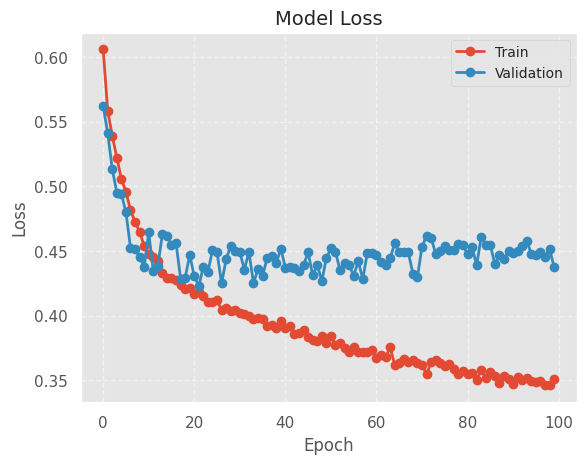

In [ ]:
plot_loss(history_5)

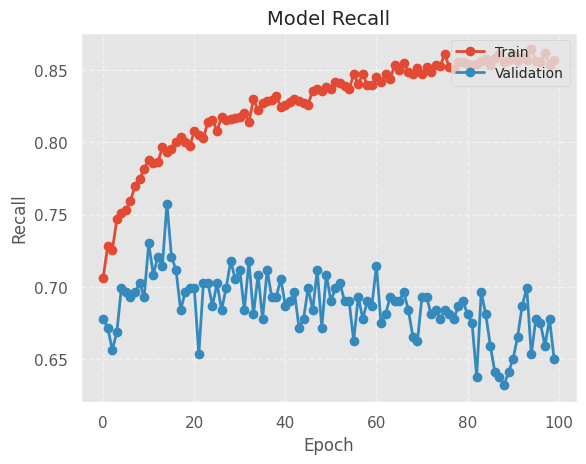

In [ ]:
plot_hist_recall(history_5)

**Observation**

The model consistently learns during training, with validation loss stabilizing and training recall plateauing, indicating potential generalization issues on the validation set.

In [ ]:
y_train_pred = model_5.predict(X_train_smote)
#Predicting the results using 0.5 as the threshold
y_train_pred = (y_train_pred > 0.5)
y_train_pred

319/319 [==============================] - 1s 2ms/step


array([[ True],
       [False],
       [False],
       ...,
       [ True],
       [ True],
       [ True]])

In [ ]:
y_val_pred = model_5.predict(X_val)
#Predicting the results using 0.5 as the threshold
y_val_pred = (y_val_pred > 0.5)
y_val_pred

50/50 [==============================] - 0s 2ms/step


array([[False],
       [False],
       [False],
       ...,
       [False],
       [ True],
       [ True]])

In [ ]:
model_name = "NN with SMOTE, Adam & Dropout"

train_metrics_df.loc[model_name] = recall_score(y_train_smote,y_train_pred)
valid_metrics_df.loc[model_name] = recall_score(y_val,y_val_pred)

####**Classification Report**

In [ ]:
print_classification_report(y_train_smote, y_train_pred, model_name, title='Training Set Classification Report')


Training Set Classification Report
----------------------------------
Model: NN with SMOTE,Adam & Dropout

              precision  recall  f1-score  support
0.0                0.89    0.88      0.88  5096.00
1.0                0.88    0.89      0.88  5096.00
accuracy           0.88    0.88      0.88     0.88
macro avg          0.88    0.88      0.88 10192.00
weighted avg       0.88    0.88      0.88 10192.00

--------------------------------------------------------------------------------



In [ ]:
print_classification_report(y_val, y_val_pred, model_name, title='Validation Set Classification Report')



Validation Set Classification Report
------------------------------------
Model: NN with SMOTE,Adam & Dropout

              precision  recall  f1-score  support
0.0                0.91    0.86      0.88  1274.00
1.0                0.54    0.65      0.59   326.00
accuracy           0.82    0.82      0.82     0.82
macro avg          0.72    0.75      0.74  1600.00
weighted avg       0.83    0.82      0.82  1600.00

--------------------------------------------------------------------------------



####**Confusion Matrix**

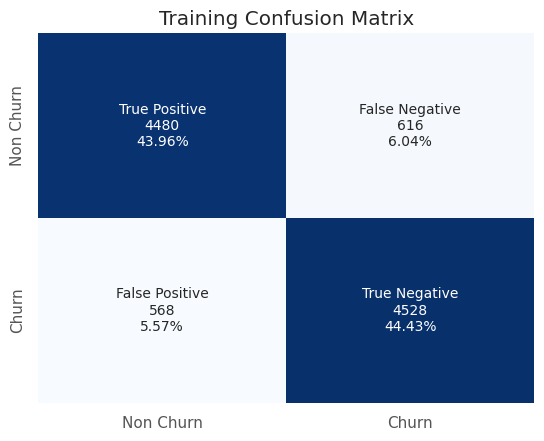

In [ ]:
make_confusion_matrix(y_train_smote, y_train_pred, title="Training Confusion Matrix")

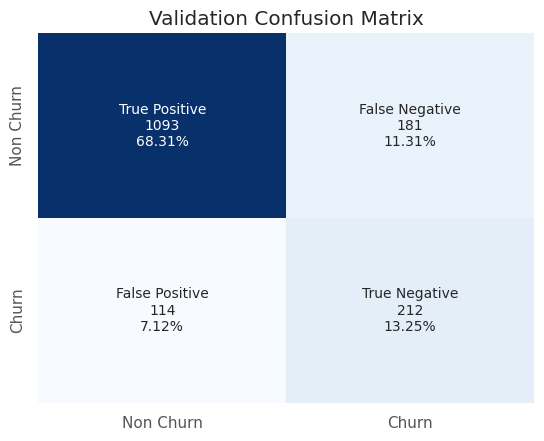

In [ ]:
make_confusion_matrix(y_val, y_val_pred, title="Validation Confusion Matrix")

## Model Performance Comparison and Final Model Selection

In [ ]:
combined_df = pd.concat([train_metrics_df, valid_metrics_df], axis=1)
combined_df.columns = ['Training Recall', 'Validation Recall']
combined_df['Difference'] = combined_df['Training Recall'] - combined_df['Validation Recall']
print("Combined Performance Metrics")
print(combined_df)

Combined Performance Metrics
                              Training Recall  Validation Recall  Difference
NN with SGD                              0.23               0.17        0.06
NN with Adam                             0.84               0.47        0.37
NN with Adam & Dropout                   0.84               0.48        0.37
NN with SMOTE & SGD                      0.75               0.68        0.07
NN with SMOTE & Adam                     0.99               0.48        0.51
NN with SMOTE,Adam & Dropout             0.89               0.65        0.24


In [ ]:
X_test = np.asarray(X_test).astype(np.float32)

In [ ]:
#Best Model Choice
name = "NN with SMOTE & SGD"
best_model = model_3


In [ ]:
y_test_pred = best_model.predict(X_test)
y_test_pred = (y_test_pred > 0.5)
print(y_test_pred)

63/63 [==============================] - 0s 2ms/step
[[False]
 [False]
 [False]
 ...
 [ True]
 [False]
 [False]]


In [ ]:
print_classification_report(y_test, y_test_pred, model_name='Best Model', title='Test Set Classification Report')


Test Set Classification Report
------------------------------
Model: Best Model

              precision  recall  f1-score  support
0                  0.92    0.77      0.83  1593.00
1                  0.44    0.73      0.55   407.00
accuracy           0.76    0.76      0.76     0.76
macro avg          0.68    0.75      0.69  2000.00
weighted avg       0.82    0.76      0.78  2000.00

--------------------------------------------------------------------------------



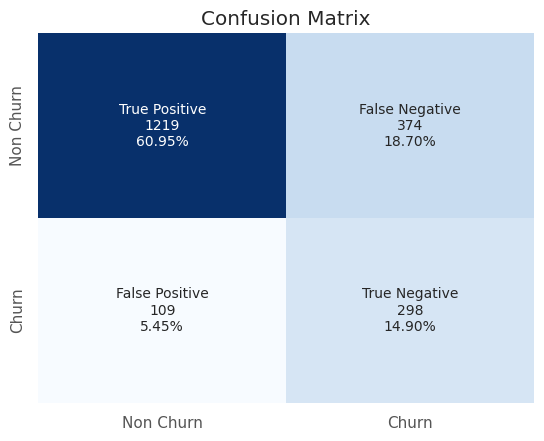

In [ ]:
make_confusion_matrix(y_test,y_test_pred)

### Model Choice


**SGD:**
Low training and validation recall, indicating it's underfitting and not learning sufficient patterns from the data.

**Adam:**
High training recall but a significant drop in validation recall, suggesting overfitting.

**Adam & Dropout:**
Moderately good training and validation recall with a small difference, indicating better generalization than Adam without dropout.

**SMOTE & SGD:**
Strong performance in both training and validation, with a close recall score and a low difference, indicating effective learning and generalization.

**SMOTE & Adam:**
Highest training recall, but the substantial drop in validation recall suggests significant overfitting.

**SMOTE, Adam & Dropout:**
High training recall and fairly good validation recall but with a notable difference, indicating some overfitting, though less severe than with Adam alone.

### Model Choice Conclusion

- The best model among the options is Nueral Network with SMOTE & SGD. Here's why:

- It demonstrates strong performance in both training and validation environments with minimal overfitting.

- This is indicated by a close recall score between training and validation and a low difference in recall.

- Essentially, this model balances learning with generalization effectively while having a strong recall.

## Actionable Insights and Business Recommendations

###The bank can take several actional steps to reduce customer churn and increase customer retention and loyalty.


### **Enhancing Digital Offerings and Customer Engagement**

  The bank should focus on improving its digital platforms and customer engagement to reduce churn. This includes enhancing the customer journey, touch points, and engagement with customer service.

### **Support and Serivce features for German Customers**
  
  Given the higher churn rate in Germany compared to France and Spain, the bank should review and improve its service delivery and customer support operations for German customers.

### **Increasing Product Engagement**

  Customers who use more products show less churn. The bank should encourage more engagement with various financial products like savings, credit cards, mortgages, and loans.

### **Retaining Credit-Worthy Customers**

  Customers with higher credit scores show more churn. The bank should take measures to retain these customers, possibly through deals on credit card usage, cash back, and reward points.

### **Targeting Younger Customers**

  Younger customers show more churn. The bank should introduce age-relevant products to increase customer loyalty among this demographic.

### **Marketing Credit Cards**

  Customers who own credit cards show less churn, indicating the attractiveness of the credit card product. The bank should market credit cards more aggressively and enhance them with features like cash backs and reward points.

### **Digital Platform Engagement**

  Customers who actively engage with the bank via digital platforms show less churn. The bank should encourage more customers to use digital platforms to enhance the customer journey and experience.

### **Addressing Low Expected Salary Customers**

  Customers with low expected salaries show higher churn. The bank should introduce products that are attractive to lower to middle-class earners, such as incentives for using banking products, lower interest rates, lower penalties, and lower or no minimum balance requirements.

### **Feedback and Customer Experience**

  The bank should conduct frequent surveys to understand customer needs better and incorporate feedback loops across all channels and customer touchpoints. This approach can help create exceptional customer experiences, drive customer loyalty, and reduce churn.

